## 1. About this notebook

In this notebook I try a few different models to predict the time to failure during earthquake simulations (LANL competition). Every model is implemented trough a Scikit-learn pipeline and compared using cross-validation scores and visualizations.

For more details about LANL competition you can check my [previous kernel](https://www.kaggle.com/jsaguiar/seismic-data-exploration).

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from boruta import BorutaPy
# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# Sklearn utilities
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel
# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()
init_notebook_mode(connected=True)

This competition has a single feature (seismic signal) and we must predict the time to failure:

In [2]:
data_type = {'acoustic_data': np.int16, 'time_to_failure': np.float32}
train = pd.read_csv('../input/train.csv', dtype=data_type)
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


## 2. Feature Engineering

The idea is to group the acoustic data in chunks and extract the following features:

* Aggregations: min, max, mean and std
* Absolute features: max, mean and std
* Quantile features
* Trend features
* Rolling features
* Ratios

In [3]:
def add_trend_feature(arr, abs_values=False):
    """Fit a univariate linear regression and return the coefficient."""
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def extract_features_from_segment(x):
    """Returns a dictionary with the features for the given segment of acoustic data."""
    features = {}
    
    features['ave'] = x.values.mean()
    features['std'] = x.values.std()
    features['max'] = x.values.max()
    features['min'] = x.values.min()
    features['q90'] = np.quantile(x.values, 0.90)
    features['q95'] = np.quantile(x.values, 0.95)
    features['q99'] = np.quantile(x.values, 0.99)
    features['q05'] = np.quantile(x.values, 0.05)
    features['q10'] = np.quantile(x.values, 0.10)
    features['q01'] = np.quantile(x.values, 0.01)
    features['std_to_mean'] = features['std'] / features['ave']
    
    features['abs_max'] = np.abs(x.values).max()
    features['abs_mean'] = np.abs(x.values).mean()
    features['abs_std'] = np.abs(x.values).std()
    features['trend'] = add_trend_feature(x.values)
    features['abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_min = x.rolling(w).min().dropna().values
        x_roll_max = x.rolling(w).max().dropna().values
        
        features['ave_roll_std_' + str(w)] = x_roll_std.mean()
        features['std_roll_std_' + str(w)] = x_roll_std.std()
        features['max_roll_std_' + str(w)] = x_roll_std.max()
        features['min_roll_std_' + str(w)] = x_roll_std.min()
        features['q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        features['q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        features['q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        features['q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        features['q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        features['ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        features['std_roll_mean_' + str(w)] = x_roll_mean.std()
        features['max_roll_mean_' + str(w)] = x_roll_mean.max()
        features['min_roll_mean_' + str(w)] = x_roll_mean.min()
        features['q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        features['q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        
        features['ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        features['std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        features['q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        features['q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        
        features['std_roll_min_' + str(w)] = x_roll_min.std()
        features['max_roll_min_' + str(w)] = x_roll_min.max()
        features['q05_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.05)
        features['q95_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.95)

        features['std_roll_max_' + str(w)] = x_roll_max.std()
        features['min_roll_max_' + str(w)] = x_roll_max.min()
        features['q05_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.05)
        features['q95_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.95)
    return features

Functions for extracting features and creating dataframes. Make train also returns one Series with the target variable and another one with the earthquake number for each segment. 

In [4]:
def make_train(train_data, size=150000, skip=150000):
    num_segments = int(np.floor((train_data.shape[0] - size) / skip)) + 1
    features_list = []
    target_list = []
    quake_num = []
    quake_count = 0
    
    for index in tqdm_notebook(range(num_segments)):
        seg = train_data.iloc[index*skip:index*skip + size]
        
        target_list.append(seg.time_to_failure.values[-1])
        features_list.append(extract_features_from_segment(seg.acoustic_data))
        
        # From which quake does the segment come from
        quake_num.append(quake_count)
        if any(seg.time_to_failure.diff() > 5):
            quake_count += 1
    return pd.DataFrame(features_list), pd.Series(target_list), pd.Series(quake_num)


def make_test():
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(index=submission.index, dtype=np.float64)
    features_list = []
    
    for seg_id in tqdm_notebook(submission.index):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        features_list.append(extract_features_from_segment(seg.acoustic_data))
    return pd.DataFrame(features_list)

In [5]:
X_train, target, quake = make_train(train, skip=150000)
print("Train shape:", X_train.shape)
X_train.head(3)


Train shape: (4194, 124)


,abs_max,abs_mean,abs_std,abs_trend,ave,ave_roll_abs_mean_10,ave_roll_abs_mean_100,ave_roll_abs_mean_1000,ave_roll_abs_mean_50,ave_roll_mean_10,ave_roll_mean_100,ave_roll_mean_1000,ave_roll_mean_50,ave_roll_std_10,ave_roll_std_100,ave_roll_std_1000,ave_roll_std_50,max,max_roll_mean_10,max_roll_mean_100,max_roll_mean_1000,max_roll_mean_50,max_roll_min_10,max_roll_min_100,max_roll_min_1000,max_roll_min_50,max_roll_std_10,max_roll_std_100,max_roll_std_1000,max_roll_std_50,min,min_roll_max_10,min_roll_max_100,min_roll_max_1000,min_roll_max_50,min_roll_mean_10,min_roll_mean_100,min_roll_mean_1000,min_roll_mean_50,min_roll_std_10,...,q95_roll_mean_10,q95_roll_mean_100,q95_roll_mean_1000,q95_roll_mean_50,q95_roll_min_10,q95_roll_min_100,q95_roll_min_1000,q95_roll_min_50,q95_roll_std_10,q95_roll_std_100,q95_roll_std_1000,q95_roll_std_50,q99,q99_roll_std_10,q99_roll_std_100,q99_roll_std_1000,q99_roll_std_50,std,std_roll_abs_mean_10,std_roll_abs_mean_100,std_roll_abs_mean_1000,std_roll_abs_mean_50,std_roll_max_10,std_roll_max_100,std_roll_max_1000,std_roll_max_50,std_roll_mean_10,std_roll_mean_100,std_roll_mean_1000,std_roll_mean_50,std_roll_min_10,std_roll_min_100,std_roll_min_1000,std_roll_min_50,std_roll_std_10,std_roll_std_100,std_roll_std_1000,std_roll_std_50,std_to_mean,trend
0,104,5.576567,4.333310,-0.000011,4.884113,5.576566,5.576655,5.579118,5.576561,4.884088,4.883864,4.883418,4.883969,3.507118,4.050450,4.288590,4.011743,104,68.5,10.04,5.629,12.82,32.0,1.0,-2.0,3.0,78.313047,52.335255,31.029445,61.404926,-98,-18.0,8.0,12.0,7.0,-60.0,1.04,3.896,-3.10,0.421637,...,8.1,5.58,5.338,5.80,4.0,-1.0,-3.0,0.0,7.226494,8.195903,8.185756,8.310922,18.0,15.034220,16.948797,15.055998,17.430339,5.101089,2.897799,2.193084,1.612370,2.302065,4.568265,6.594138,11.064159,5.891685,2.801800,0.452294,0.295715,0.606039,4.526280,6.522304,11.248606,5.787738,2.809071,3.111524,2.769772,3.176148,1.044425,-3.268300e-06
1,181,5.734167,5.732758,-0.000005,4.725767,5.734187,5.734653,5.739510,5.734444,4.725732,4.725623,4.724876,4.725729,3.761435,4.436359,4.843486,4.379248,181,145.1,16.67,5.667,28.26,91.0,1.0,-2.0,2.0,122.978273,87.972617,38.643217,94.730087,-154,-99.0,8.0,11.0,7.0,-128.0,-4.09,3.412,-13.30,0.421637,...,8.2,5.39,5.066,5.64,4.0,-1.0,-3.0,0.0,8.265726,9.829922,10.544982,9.882948,21.0,18.772705,23.457270,33.704332,23.233021,6.588802,4.403190,3.563252,2.399157,3.752625,6.615549,10.727877,21.604075,9.299945,3.924070,0.496220,0.231587,0.764507,6.398675,10.162552,21.096014,8.823748,4.120785,4.893431,4.492905,4.953472,1.394229,9.090424e-07
2,140,6.152647,5.895925,0.000010,4.906393,6.152557,6.153045,6.159850,6.152678,4.906229,4.906088,4.905840,4.906072,4.080841,4.917334,5.423013,4.849219,140,94.8,12.38,5.957,17.36,60.0,2.0,-2.0,2.0,96.247424,53.353832,35.326896,65.431379,-106,-33.0,8.0,11.0,7.0,-72.9,-1.55,4.055,-7.72,0.516398,...,9.1,5.66,5.344,5.94,4.0,-1.0,-3.0,0.0,10.211649,13.485267,14.845834,13.127670,26.0,23.865014,28.598375,23.928873,29.448105,6.967374,4.429093,3.516817,2.414414,3.699345,6.789628,10.729778,19.898844,9.372244,4.179729,0.530151,0.267012,0.811309,6.641086,10.535572,19.047827,9.125804,4.227960,4.959233,4.402140,5.035827,1.420060,3.962182e-06


## 3. Cross-validation strategy

Since there are only four thousand samples, it is better to use cross-validation instead of a simple split for validation. This can be implemented trough a generator, so it is easy to change our strategy. I am using KFold, but you can try a [Group KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) with the quake series or [Stratified KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) if you prefer.

In [6]:
def fold_generator(x, y, groups=None, num_folds=10, shuffle=True, seed=2019):
    folds = KFold(num_folds, shuffle=shuffle, random_state=seed)
    for train_index, test_index in folds.split(x, y, groups):
        yield train_index, test_index

## 4. Feature Selection

One option for selecting features is the [Boruta package](https://www.jstatsoft.org/article/view/v036i11) with a Random Forests model.

In [7]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
# define Boruta feature selection method
selector = BorutaPy(rf, n_estimators='auto', verbose=0,
                    random_state=1, max_iter=500)
# find all relevant features
selector.fit(X_train.values, target.values)
# transform values
X_filtered = selector.transform(X_train.values)
X_train = pd.DataFrame(X_filtered, columns=X_train.columns[selector.support_])
X_train.head()

,min_roll_mean_1000,q05_roll_abs_mean_1000,q05_roll_mean_1000,q05_roll_std_10,q05_roll_std_100,q05_roll_std_1000,q05_roll_std_50,q10_roll_std_10,q10_roll_std_100,q10_roll_std_1000,q10_roll_std_50,q95_roll_mean_1000,std_roll_mean_50
0,3.896,4.589,4.379,1.636392,2.475639,2.706474,2.331768,1.873796,2.576114,2.770139,2.465766,5.338,0.606039
1,3.412,4.552,4.345,1.646545,2.475965,2.674879,2.345991,1.873796,2.576820,2.729840,2.478973,5.066,0.764507
2,4.055,4.717,4.446,1.686548,2.538591,2.761534,2.404163,1.911951,2.645274,2.829290,2.540207,5.344,0.811309
3,3.722,4.658,4.433,1.649916,2.496442,2.716991,2.368501,1.888562,2.595470,2.773216,2.492519,5.317,0.959834
4,3.918,4.714,4.543,1.646545,2.491521,2.719174,2.365052,1.885618,2.596404,2.792436,2.497672,5.306,0.903958


## 5. Making a Pipeline

We will be using a Sklearn Pipeline to perform hyperparameter search and to make predictions. The advantage of using a pipeline is that we are not leaking information from the training to the validation set.

The feature selection could also be moved to this pipeline, but it would take too long to perform the grid search.

In [8]:
def make_pipeline(estimator):
    pipeline = Pipeline([
        # Each item is a tuple with a name and a transformer or estimator
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    return pipeline

The next cell has two functions: one for searching the best hyperparameters and another for making predictions and ploting.

In [9]:
def search_cv(x, y, pipeline, grid, max_iter=None, num_folds=10, shuffle=True):
    """Search hyperparameters and returns a estimator with the best combination found."""
    t0 = time.time()
    
    cv = fold_generator(x, y, num_folds=num_folds)
    if max_iter is None:
        search = GridSearchCV(pipeline, grid, cv=cv,
                              scoring='neg_mean_absolute_error')
    else:
        search = RandomizedSearchCV(pipeline, grid, n_iter=max_iter, cv=cv,
                                    scoring='neg_mean_absolute_error')
    search.fit(x, y)
    
    t0 = time.time() - t0
    print("Best CV score: {:.4f}, time: {:.1f}s".format(-search.best_score_, t0))
    print(search.best_params_)
    return search.best_estimator_


def make_predictions(x, y, pipeline, num_folds=10, shuffle=True, test=None, plot=True):
    """Train, make predictions (oof and test data) and plot."""
    if test is not None:
        sub_prediction = np.zeros(test.shape[0])
        
    oof_prediction = np.zeros(x.shape[0])
    for tr_idx, val_idx in fold_generator(x, y, num_folds=num_folds):
        pipeline.fit(x.iloc[tr_idx], y.iloc[tr_idx])
        oof_prediction[val_idx] = pipeline.predict(x.iloc[val_idx])

        if test is not None:
            sub_prediction += pipeline.predict(test) / num_folds
    
    if plot:
        plot_predictions(y, oof_prediction)
    if test is None:
        return oof_prediction
    else:
        return oof_prediction, sub_prediction

In [10]:
def plot_predictions(y, oof_predictions):
    """Plot out-of-fold predictions vs actual values."""
    fig, axis = plt.subplots(1, 2, figsize=(14, 6))
    ax1, ax2 = axis
    ax1.set_xlabel('actual')
    ax1.set_ylabel('predicted')
    ax1.set_ylim([-5, 20])
    ax2.set_xlabel('train index')
    ax2.set_ylabel('time to failure')
    ax2.set_ylim([-2, 18])
    ax1.scatter(y, oof_predictions, color='brown')
    ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
    ax2.plot(y, color='blue', label='y_train')
    ax2.plot(oof_predictions, color='orange')

## 6. Testing Models

The predicted values in the following plots are using a out-of-fold scheme.

### Ridge Regression

The first model is a linear regression with L2 regularization.



Best CV score: 2.1485, time: 79.1s
{'model__alpha': 9.332665330661323}


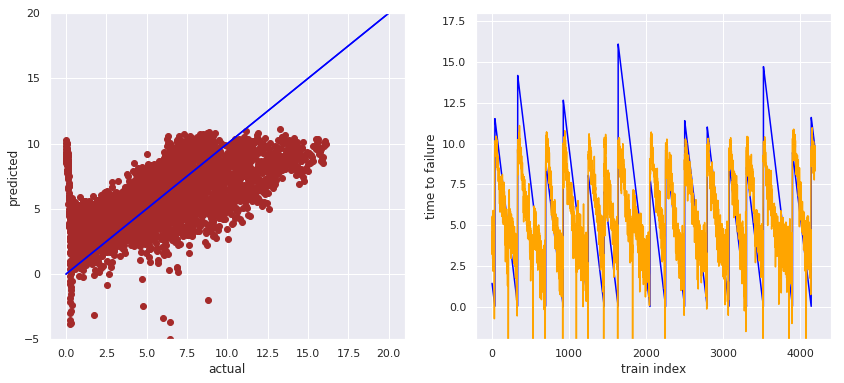

In [11]:
grid = {'model__alpha': np.concatenate([np.linspace(0.001, 1, 200),
                                        np.linspace(1, 100, 500)])}


ridge_pipe = make_pipeline(Ridge(random_state=2019))
ridge_pipe = search_cv(X_train, target, ridge_pipe, grid)
ridge_oof = make_predictions(X_train, target, ridge_pipe)

There are some negative predictions when using a linear model. We can try to change negative values for zeros:

In [12]:
ridge_oof[ridge_oof < 0] = 0
print("Mean error: {:.4f}".format(mean_absolute_error(target, ridge_oof)))

Mean error: 2.1309


### Kernel Ridge

This model combines regularized linear regression with a given kernel (radial basis in this case).

Best CV score: 2.0336, time: 1421.1s
{'model__gamma': 0.15151515999999998, 'model__alpha': 1.678392120603015}


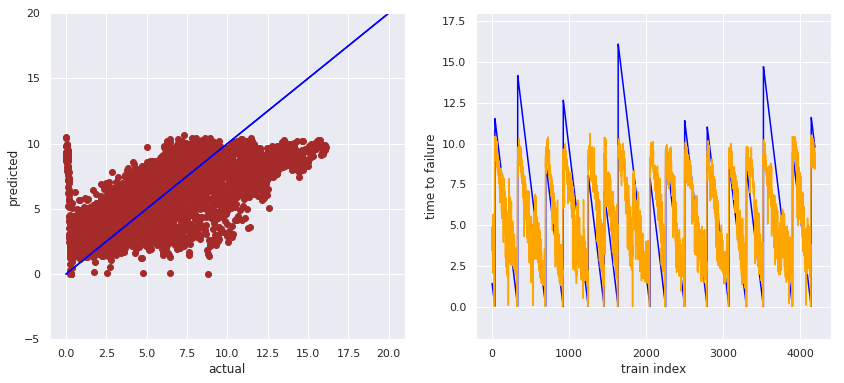

In [13]:
grid = {'model__gamma': np.linspace(1e-8, 1, 100),
        'model__alpha': np.linspace(1e-6, 2, 200)}
kr_pipe = make_pipeline(KernelRidge(kernel='rbf'))
kr_pipe = search_cv(X_train, target, kr_pipe, grid, max_iter=60)
kr_oof = make_predictions(X_train, target, kr_pipe)

### SVM
Support vector machine with radial basis function kernel.

Best CV score: 2.0108, time: 969.3s
{'model__epsilon': 0.29363636363636364, 'model__C': 4.449999999999999}


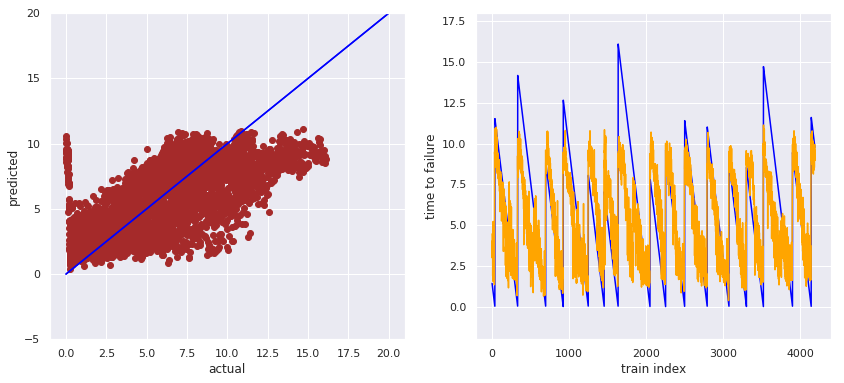

In [14]:
grid = {'model__epsilon': np.linspace(0.001, 1, 100),
        'model__C': np.linspace(0.01, 10, 100)}
svm_pipe = make_pipeline(SVR(kernel='rbf', gamma='scale'))
svm_pipe = search_cv(X_train, target, svm_pipe, grid, max_iter=60)
svm_oof = make_predictions(X_train, target, svm_pipe)

### Random Forests

This regressor fits several decision trees with a different subset of the original data for each tree. Predictions are the average between trees.

Best CV score: 2.0150, time: 1200.2s
{'model__min_samples_split': 8, 'model__min_samples_leaf': 14, 'model__max_features': 'auto', 'model__max_depth': 6}


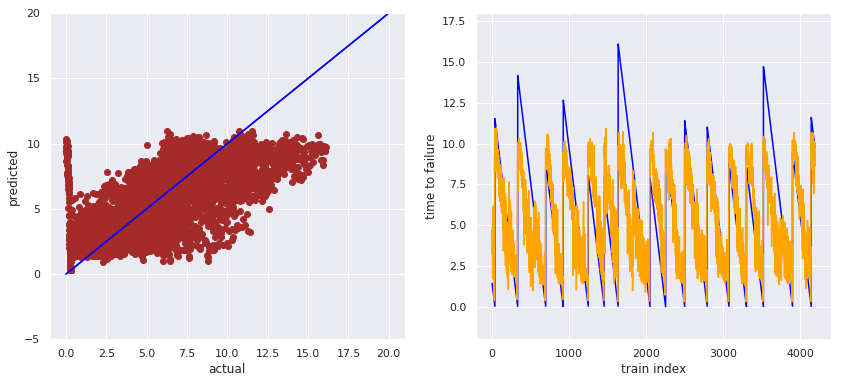

In [15]:
grid = {
    'model__max_depth': [4, 6, 8, 10, 12],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__min_samples_leaf': [2, 4, 8, 12, 14, 16, 20],
    'model__min_samples_split': [2, 4, 6, 8, 12, 16, 20],
}
rf_pipe = make_pipeline(RandomForestRegressor(criterion='mae', n_estimators=40))
rf_pipe = search_cv(X_train, target, rf_pipe, grid, max_iter=10)
rf_oof = make_predictions(X_train, target, rf_pipe)

### Ada Boost

AdaBoost is a sequential ensemble model which begins by fitting a base estimator on the original dataset and then fits additional copies on the same dataset. At each iteration (estimator), the weights of instances are adjusted according to the error of the last prediction. It's similar to the next model, but gradient boosting fits additional estimators on the current pseudo-error and not on the original target.

Best CV score: 2.1471, time: 78.5s
{'model__learning_rate': 1e-05}


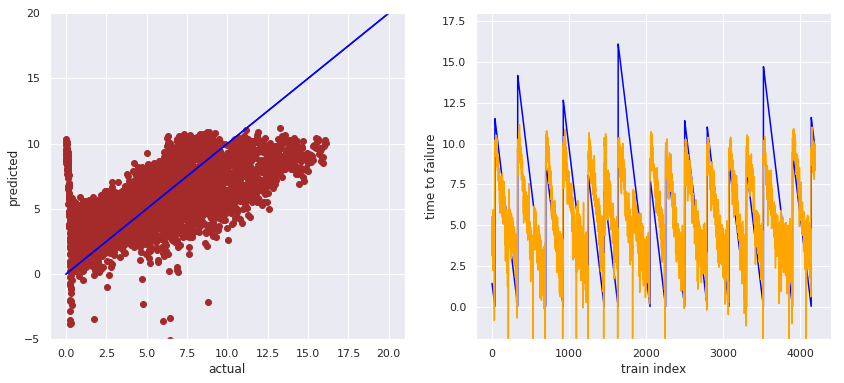

In [17]:
grid = {'model__learning_rate': np.linspace(1e-5, 0.9, 100)}
base = Ridge(alpha=2)

ada_pipe = make_pipeline(AdaBoostRegressor(base_estimator=base, n_estimators=200))
ada_pipe = search_cv(X_train, target, ada_pipe, grid)
ada_oof = make_predictions(X_train, target, ada_pipe)

### Gradient Boosting

The last model is a gradient boosting decision tree. It's not possible to use GridSearchCV with early stopping (lightgbm), so I am using a custom function for random search.

In [18]:
fixed_params = {
    'objective': 'regression_l1',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'n_estimators': 80000,
    'max_depth': -1
}

param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(2, 60, 2)),
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.2, 0.4, 0.6, 0.8, 2, 5],
    'lambda_l2': [0, 0.2, 0.4, 0.6, 0.8, 2, 5],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
}

best_score = 999
dataset = lgb.Dataset(X_train, label=target)  # no need to scale features

for i in range(600):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    params.update(fixed_params)
    result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100,
                    stratified=False)
    
    if result['l1-mean'][-1] < best_score:
        best_score = result['l1-mean'][-1]
        best_params = params
        best_nrounds = len(result['l1-mean'])

In [ ]:
print("Best mean score: {:.4f}, num rounds: {}".format(best_score, best_nrounds))
print(best_params)
gb_pipe = make_pipeline(lgb.LGBMRegressor(**best_params))
gb_oof = make_predictions(X_train, target, gb_pipe)

Best mean score: 2.0061, num rounds: 849
{'learning_rate': 0.01, 'num_leaves': 6, 'feature_fraction': 0.85, 'subsample': 1, 'lambda_l1': 0.6, 'lambda_l2': 0.2, 'min_data_in_leaf': 20, 'min_gain_to_split': 0, 'objective': 'regression_l1', 'boosting': 'gbdt', 'verbosity': -1, 'random_seed': 19, 'n_estimators': 80000, 'max_depth': -1}


Now let's have a look at the <b>feature importance</b>:

In [ ]:
def plot_feature_importance(x, y, columns):
    importance_frame = pd.DataFrame()
    for (train_index, valid_index) in fold_generator(x, y):
        reg = lgb.LGBMRegressor(**best_params)
        reg.fit(x.iloc[train_index], y.iloc[train_index],
                early_stopping_rounds=100, verbose=False,
                eval_set=[(x.iloc[train_index], y.iloc[train_index]),
                          (x.iloc[valid_index], y.iloc[valid_index])])
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["gain"] = reg.booster_.feature_importance(importance_type='gain')
        #fold_importance["split"] = reg.booster_.feature_importance(importance_type='split')
        importance_frame = pd.concat([importance_frame, fold_importance], axis=0)
        
    mean_importance = importance_frame.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by='gain', ascending=True, inplace=True)
    trace = go.Bar(y=mean_importance.feature, x=mean_importance.gain,
                   orientation='h', marker=dict(color='rgb(49,130,189)'))

    layout = go.Layout(
        title='Feature importance', height=800, width=600,
        showlegend=False,
        xaxis=dict(
            title='Importance by gain',
            titlefont=dict(size=14, color='rgb(107, 107, 107)'),
            domain=[0.15, 1]
        ),
    )

    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    
plot_feature_importance(X_train, target, X_train.columns)

## 7. Submission

In [ ]:
X_test = make_test()
X_test = X_test[X_train.columns]  # feature selection
gb_oof, gb_sub = make_predictions(X_train, target, gb_pipe,
                                  test=X_test, plot=False)
submission = pd.read_csv('../input/sample_submission.csv')
submission['time_to_failure'] = gb_sub
submission.to_csv('submission_gb.csv', index=False)
submission.time_to_failure.describe()